# Turning xml's into cvs's
For all commands, we'll be in the python 3.9 igwn environment, or the singularity itself

`conda activate igwn-py39`

Run stuff in this order

 - Creating a Map from Gamma0 to Bank Properties from split_banks
   - `python make_split_bank_map.py`
     - `--inDir <Directory where split banks are located>`
     - `--outFile <File storing split bank information>`
     - `--tempDir <Path to Temporary Directory for temporary trash files>`
     - `--tag <Tag name or number identifying temporary files with this run>`
 - Turning Triggers (sqlite) to csv files
   - `python3 trigger_sqlite_to_csv.py`
     - `--inFile <Path to sqlite file containing the triggers>`
     - `--outFile <Path to the output csv file>`
     - `--bankMapFile <Path to Bank Map csv>`
   - Notes: There are quite a few Sqlites, they should be at `<Run Directory>/rank/triggers/<SmallestTimeStamp>/*.sqlite`, run the command for all, with appropriate names. You'll see that there's one with the "ALL" keyword in the filename, and one without. I'm still seeing the difference. They have a large number of common triggers, but also quite a few unique to themselves. The one without "ALL" seems to be larger...
 - Turning segments.xml.gz file to csv file
   - `python segments_xml_to_csv.py`
     - `--inFile <Path to segments file>` 
     - `--outFile <Path to output segments file>`
 - Turning vetoes.xml.gz file to csv file
   - `python vetoes_xml_to_csv.py`
     - `--inFile <Path to segments file>` 
     - `--outFile <Path to output segments file>`
     


# Imports and Definitions

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.stats import ks_2samp as ksTest
import matplotlib.pyplot as plt
import matplotlib
import gwpy
import os
from os.path import isfile, join
from os import listdir
from IPython.display import clear_output
import time
import pickle as pkl
from matplotlib import cm
import warnings
from scipy import interpolate

# %matplotlib inline

In [2]:
def chirpMass(m1, m2):
    return (m1*m2)**(3/5)/((m1+m2)**(1/5))

def eta(m1, m2):
    return (m1*m2)/((m1+m2)**2)

def bestbandwidth(data):
    return 1.06*np.std(data)*len(data)**(-1/5)

def whichBin(bins, value):
    for i in range(len(bins)-1):
        if bins[i] <= value < bins[i+1]:
            return i
    return i

def jsd(sample_a, sample_b, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    
    bestbw = 1/2*(bestbandwidth(sample_a) + bestbandwidth(sample_b))
    minVal = min([min(sample_a),min(sample_b)])
    maxVal = max([max(sample_a),max(sample_b)])
    bins = np.linspace(minVal, maxVal, num = int((maxVal - minVal)/bestbw))

    p, _ = np.histogram(sample_a, density = True, bins = bins)
    q, _ = np.histogram(sample_b, density = True, bins = bins)

    p /= p.sum()
    q /= q.sum()

    m = 1./2*(p + q)
    
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

def ks(sample_a, sample_b, percentile = 0):
    cutoff_high = np.percentile(sample_b, percentile)
    sample_a = sample_a[(sample_a >= cutoff_high)]
    sample_b = sample_b[(sample_b >= cutoff_high)]
    return ksTest(sample_a, sample_b)[0]

def n_outliers(sample_a, sample_b):
    outliers_a = sample_a[(sample_a <= min(sample_b)) | (sample_a >= max(sample_b))]
    outliers_b = sample_b[(sample_b <= min(sample_a)) | (sample_b >= max(sample_a))]
    return (len(outliers_a) + len(outliers_b))


# Loading Files and Filtering

In [3]:
# Name of run directory
runName = 'sparse_banks_151234'

ifoOrder = ['H1','L1','V1']
ifo = 'H1'
bankCAT = 'ALL'
param = "likelihood"
paramName = "$\\log\\left(\\mathcal{L}\\right)$"
#paramName = r"$log\left(\mathcal{L}\right)$"

logX = False
logY = True

# Creating Plots directory, if none is provided
if not 'plots' in [f for f in listdir('runResults/' + runName)]:
    os.system("mkdir -p runResults/ + " + runName + "/plots")

# The Interferometers to consider
ifos = ['H1', 'L1', 'V1']

# Loading triggers for the LIGO run
print("Loading LIGO Run Triggers")
triggersLIGO = pd.read_csv('runResults/' + runName + '/triggers_12645.csv', low_memory=False).drop("Unnamed: 0", axis = "columns")
# Loading triggers for the Compare run
print("Loading Compare Run Triggers")
triggersCompare = pd.read_csv('runResults/' + runName + '/triggers_12645_gaussian_1.csv', low_memory=False).drop("Unnamed: 0", axis = "columns")
# Loading triggers for the Control run
print("Loading Control Run Triggers")
triggersControl = pd.read_csv('runResults/' + runName + '/triggers_12645_gaussian_2.csv', low_memory=False).drop("Unnamed: 0", axis = "columns")

#Loading Bank Parameters
bankParameters = pd.read_csv('runResults/' + runName + '/split_bank_map.csv')

# Loading Real Run Segments File
print("Loading Segments File")
segments = pd.read_csv('runResults/' + runName + '/segments.csv').drop("Unnamed: 0", axis = "columns")

# Loading Glitches File
print("Loading Gliches File")
glitches = pd.read_csv("O3glitches.csv").drop("Unnamed: 0", axis = "columns")


Loading LIGO Run Triggers
Loading Compare Run Triggers
Loading Control Run Triggers
Loading Segments File
Loading Gliches File


# Filtering Data

In [4]:
# Filtering according to Interferometer
print("Filtering data by ifo")
triggersLIGO = triggersLIGO[triggersLIGO['ifo'] == ifo]
triggersCompare = triggersCompare[triggersCompare['ifo'] == ifo]
triggersControl = triggersControl[triggersControl['ifo'] == ifo]
segments = segments[segments['ifo'] == ifo]
glitches = glitches[glitches['ifo'] == ifo]

# Filtering according to segments
print("Filtering data by segments")
maskTriggersLIGO = [False for _ in range(len(triggersLIGO))]
maskTriggersCompare = [False for _ in range(len(triggersCompare))]
maskTriggersControl = [False for _ in range(len(triggersControl))]
maskGlitches = [False for _ in range(len(glitches))]
for idx, row in segments.iterrows():
    temp = list((triggersLIGO['end_time'] >= row['start_time']) & (triggersLIGO['end_time'] <= row['end_time']))
    maskTriggersLIGO = [x|y for (x,y) in zip(maskTriggersLIGO, temp)]
    
    temp = list((triggersCompare['end_time'] >= row['start_time']) & (triggersCompare['end_time'] <= row['end_time']))
    maskTriggersCompare = [x|y for (x,y) in zip(maskTriggersCompare, temp)]
    
    temp = list((triggersControl['end_time'] >= row['start_time']) & (triggersControl['end_time'] <= row['end_time']))
    maskTriggersControl = [x|y for (x,y) in zip(maskTriggersControl, temp)]
    
    temp = list((glitches['GPStime'] >= row['start_time']) & (glitches['GPStime'] <= row['end_time']))
    maskGlitches = [x|y for (x,y) in zip(maskGlitches, temp)]
    
triggersLIGO = triggersLIGO[maskTriggersLIGO]
triggersCompare = triggersCompare[maskTriggersCompare]
triggersControl = triggersControl[maskTriggersControl]
glitches = glitches[maskGlitches]

# Filtering according to Template Region
print("Filtering data by template region")
if bankCAT == 'BNS':
    maskLIGO = (triggersLIGO['mass1'] < 3) & (triggersLIGO['mass2'] < 3)
    maskBank = (bankParameters['mass1'] < 3) & (bankParameters['mass2'] < 3)
    maskCompare = (triggersCompare['mass1'] < 3) & (triggersCompare['mass2'] < 3)
    maskControl = (triggersControl['mass1'] < 3) & (triggersControl['mass2'] < 3)
elif bankCAT == 'NSBH':
    maskLIGO = (triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] < 3)
    maskBank = (bankParameters['mass1'] >= 3) & (bankParameters['mass2'] < 3)
    maskCompare = (triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] < 3)
    maskControl = (triggersControl['mass1'] >= 3) & (triggersControl['mass2'] < 3)
elif bankCAT == 'BBH':
    maskLIGO = (triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] >= 3) & (triggersLIGO['mass1'] + triggersLIGO['mass2'] < 100) & (triggersLIGO['mass1']/triggersLIGO['mass2'] < 10)
    maskBank = (bankParameters['mass1'] >= 3) & (bankParameters['mass2'] >= 3) & (bankParameters['mass1'] + bankParameters['mass2'] < 100) & (bankParameters['mass1']/bankParameters['mass2'] < 10)
    maskCompare = (triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] >= 3) & (triggersCompare['mass1'] + triggersCompare['mass2'] < 100) & (triggersCompare['mass1']/triggersCompare['mass2'] < 10)
    maskControl = (triggersControl['mass1'] >= 3) & (triggersControl['mass2'] >= 3) & (triggersControl['mass1'] + triggersControl['mass2'] < 100) & (triggersControl['mass1']/triggersControl['mass2'] < 10)
elif bankCAT == 'IMBH':
    maskLIGO = (triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] >= 3) & (triggersLIGO['mass1'] + triggersLIGO['mass2'] >= 100) & (triggersLIGO['mass1']/triggersLIGO['mass2'] < 10)
    maskBank = (bankParameters['mass1'] >= 3) & (bankParameters['mass2'] >= 3) & (bankParameters['mass1'] + bankParameters['mass2'] >= 100) & (bankParameters['mass1']/bankParameters['mass2'] < 10)
    maskCompare = (triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] >= 3) & (triggersCompare['mass1'] + triggersCompare['mass2'] >= 100) & (triggersCompare['mass1']/triggersCompare['mass2'] < 10)
    maskControl = (triggersControl['mass1'] >= 3) & (triggersControl['mass2'] >= 3) & (triggersControl['mass1'] + triggersControl['mass2'] >= 100) & (triggersControl['mass1']/triggersControl['mass2'] < 10)
elif bankCAT == 'HiQBBH':
    maskLIGO = (triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] >= 3) & (triggersLIGO['mass1']/triggersLIGO['mass2'] >= 10)
    maskBank = (bankParameters['mass1'] >= 3) & (bankParameters['mass2'] >= 3) & (bankParameters['mass1']/bankParameters['mass2'] >= 10)
    maskCompare = (triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] >= 3) & (triggersCompare['mass1']/triggersCompare['mass2'] >= 10)
    maskControl = (triggersControl['mass1'] >= 3) & (triggersControl['mass2'] >= 3) & (triggersControl['mass1']/triggersControl['mass2'] >= 10)
elif bankCAT == 'ALL':
    maskLIGO = [True]*len(triggersLIGO)
    maskBank = [True]*len(bankParameters)
    maskCompare = [True]*len(triggersCompare)
    maskControl = [True]*len(triggersControl)
    
    
triggersLIGO = triggersLIGO[maskLIGO]
bankParameters = bankParameters[maskBank]
triggersCompare = triggersCompare[maskCompare]
triggersControl = triggersControl[maskControl]


triggersLIGO['ID'] = [i for i in range(len(triggersLIGO))]
triggersCompare['ID'] = [i for i in range(len(triggersCompare))]
triggersControl['ID'] = [i for i in range(len(triggersControl))]
glitches['ID'] = [i for i in range(len(glitches))]

triggersLIGO = triggersLIGO.set_index("ID")
triggersCompare = triggersCompare.set_index("ID")
triggersControl = triggersControl.set_index("ID")
glitches = glitches.set_index("ID")

# Filtering data removing infinities
print("Filtering data by removing infinities")
triggersLIGO = triggersLIGO[abs(triggersLIGO[param]) < np.inf]
triggersCompare = triggersCompare[abs(triggersCompare[param]) < np.inf]
triggersControl = triggersControl[abs(triggersControl[param]) < np.inf]



Filtering data by ifo
Filtering data by segments
Filtering data by template region
Filtering data by removing infinities


# Calculating extra parameters

In [5]:
# Calculating chirp Mass (mchirp)
print("Calculating Chirp Mass")
triggersLIGO['mchirp'] = chirpMass(triggersLIGO['mass1'], triggersLIGO['mass2'])
triggersCompare['mchirp'] = chirpMass(triggersLIGO['mass1'], triggersLIGO['mass2'])
triggersControl['mchirp'] = chirpMass(triggersLIGO['mass1'], triggersLIGO['mass2'])
bankParameters['mchirp'] = chirpMass(bankParameters['mass1'], bankParameters['mass2'])

# Calculating Symmetric Mass Ratio (eta)
print("Calculating Symmetric Mass Ratio")
triggersLIGO['eta'] = eta(triggersLIGO['mass1'], triggersLIGO['mass2'])
triggersCompare['eta'] = eta(triggersLIGO['mass1'], triggersLIGO['mass2'])
triggersControl['eta'] = eta(triggersLIGO['mass1'], triggersLIGO['mass2'])
bankParameters['eta'] = eta(bankParameters['mass1'], bankParameters['mass2'])

# Calculating Total Mass (mtotal)
print("Calculating Total Mass")
triggersLIGO['mtotal'] = triggersLIGO['mass1'] + triggersLIGO['mass2']
triggersCompare['mtotal'] = triggersLIGO['mass1'] + triggersLIGO['mass2']
triggersControl['mtotal'] = triggersLIGO['mass1'] + triggersLIGO['mass2']
bankParameters['mtotal'] = bankParameters['mass1'] + bankParameters['mass2']

Calculating Chirp Mass
Calculating Symmetric Mass Ratio
Calculating Total Mass


# Associating glitches with triggers

In [6]:
triggerIDs = []
preferredTriggers = []
for i in range(len(glitches)):
    clear_output(wait = True)
    print(ifo + " : " + str(i) + " / " + str(len(glitches)))
    glitch = glitches.iloc[i]
    triggerCandidates = triggersLIGO[abs(triggersLIGO['end_time'] - glitch['GPStime']) <= 2*glitch['duration']]
    triggerCandidates = triggerCandidates.reset_index()
    if len(triggerCandidates) == 0:
        triggerIDs += [np.array([])]
        preferredTriggers += [np.nan]
    else:
        triggerIDs += [triggerCandidates['ID'].values]
        preferredTriggers += [triggerCandidates.sort_values('likelihood').iloc[-1]['ID']]

glitches['triggers'] = triggerIDs
glitches['preferredTrigger'] = preferredTriggers

glitches = glitches[glitches['preferredTrigger'] == glitches['preferredTrigger']]

triggersTemp = triggersLIGO.reset_index().set_index('ID')

for param_temp in triggersTemp.columns:
    glitches['trigger_' + param_temp] = triggersTemp.loc[glitches['preferredTrigger'].values][param_temp].values

del triggersTemp

H1 : 621 / 622


# Overall Trigger Distribution Example

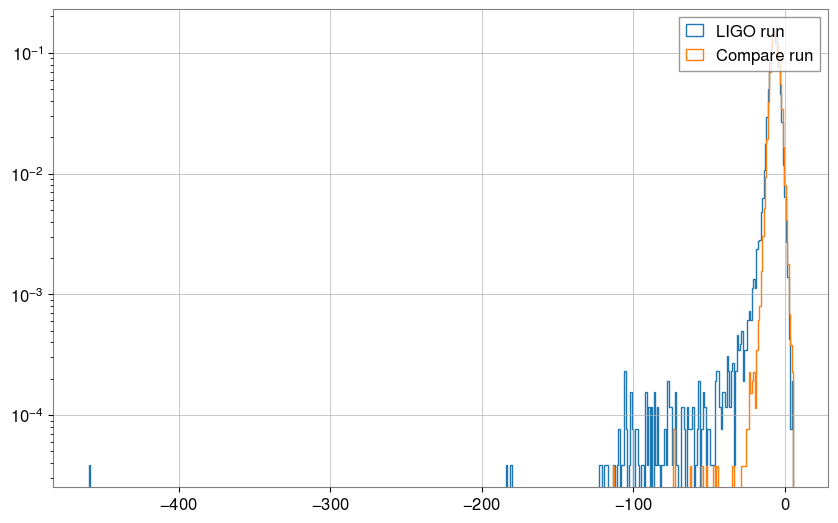

In [7]:
fig, ax = plt.subplots(figsize = [10, 10/1.61])

data = triggersLIGO[param]
bw = bestbandwidth(data)

if logX:
    bins = np.exp(np.linspace(np.log(min(data)), np.log(max(data)), num = int((max(data) - min(data))/bw)))
else:
    bins = np.linspace(min(data), max(data), num = int((max(data) - min(data))/bw))
ax.hist(triggersLIGO[param], density = True, histtype = 'step', bins = bins, label = "LIGO run")
ax.hist(triggersCompare[param], density = True, histtype = 'step', bins = bins, label = "Compare run")
if logX:
    ax.set_xscale('log')
if logY:
    ax.set_yscale('log')
ax.legend()
#ax.set_xlabel(paramName)
print()

# Calculation of JSD Comparison for a single region.


$\log\left(\mathcal{L}\right)$ JSD:			0.014812951819496555
$\log\left(\mathcal{L}\right)$ Statistical Treshold:	0.0019358794749522535


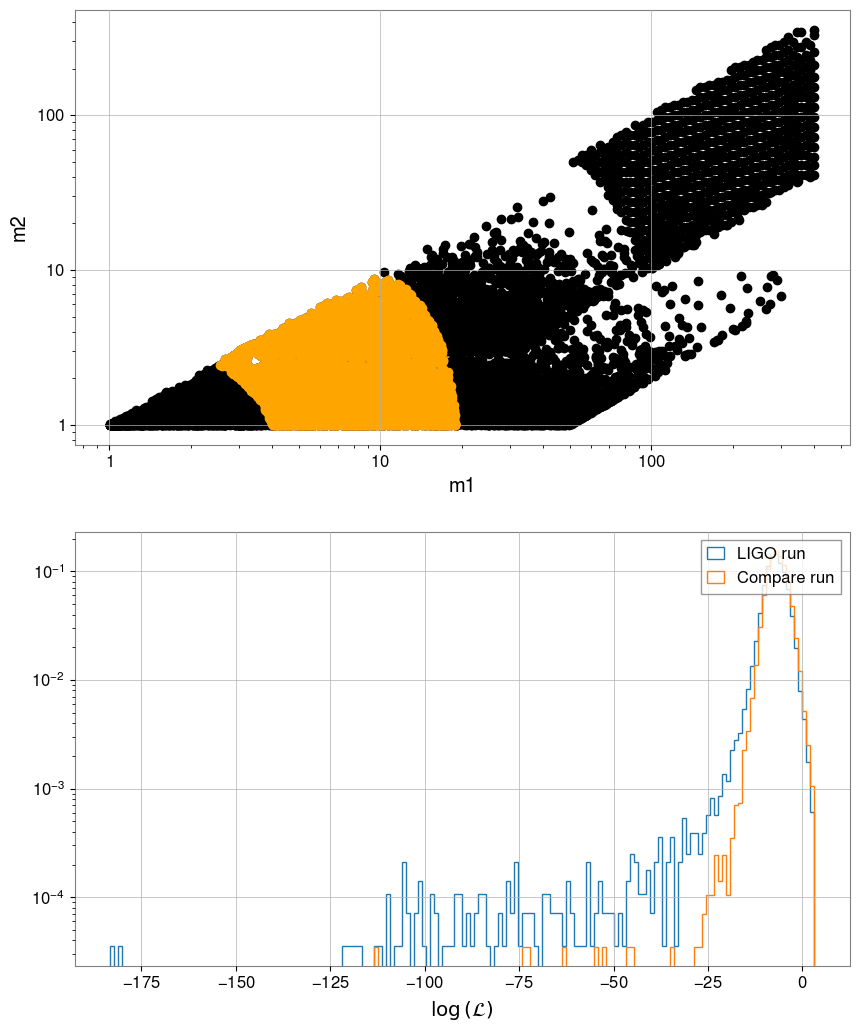

In [12]:
# Region of mtotal range
if bankCAT == 'BNS':
    bankParametersRegion = bankParameters[(bankParameters['mtotal'] >= 3) & (bankParameters['mtotal'] <= 4)]
    triggersLIGORegion = triggersLIGO[(triggersLIGO['mtotal'] >= 3) & (triggersLIGO['mtotal'] <= 4)]
    triggersCompareRegion = triggersCompare[(triggersCompare['mtotal'] >= 3) & (triggersCompare['mtotal'] <= 4)]
    triggersControlRegion = triggersControl[(triggersControl['mtotal'] >= 3) & (triggersControl['mtotal'] <= 4)]
elif bankCAT == 'NSBH':
    bankParametersRegion = bankParameters[(bankParameters['mtotal'] >= 5) & (bankParameters['mtotal'] <= 7)]
    triggersLIGORegion = triggersLIGO[(triggersLIGO['mtotal'] >= 5) & (triggersLIGO['mtotal'] <= 7)]
    triggersCompareRegion = triggersCompare[(triggersCompare['mtotal'] >= 5) & (triggersCompare['mtotal'] <= 7)]
    triggersControlRegion = triggersControl[(triggersControl['mtotal'] >= 5) & (triggersControl['mtotal'] <= 7)]
elif bankCAT == 'BBH':
    bankParametersRegion = bankParameters[(bankParameters['mtotal'] >= 5) & (bankParameters['mtotal'] <= 10)]
    triggersLIGORegion = triggersLIGO[(triggersLIGO['mtotal'] >= 5) & (triggersLIGO['mtotal'] <= 10)]
    triggersCompareRegion = triggersCompare[(triggersCompare['mtotal'] >= 5) & (triggersCompare['mtotal'] <= 10)]
    triggersControlRegion = triggersControl[(triggersControl['mtotal'] >= 5) & (triggersControl['mtotal'] <= 10)]
elif bankCAT == 'IMBH':
    bankParametersRegion = bankParameters[(bankParameters['mtotal'] >= 100) & (bankParameters['mtotal'] <= 120)]
    triggersLIGORegion = triggersLIGO[(triggersLIGO['mtotal'] >= 100) & (triggersLIGO['mtotal'] <= 120)]
    triggersCompareRegion = triggersCompare[(triggersCompare['mtotal'] >= 100) & (triggersCompare['mtotal'] <= 120)]
    triggersControlRegion = triggersControl[(triggersControl['mtotal'] >= 100) & (triggersControl['mtotal'] <= 120)]
elif bankCAT == 'HiQBBH':
    bankParametersRegion = bankParameters[(bankParameters['mtotal'] >= 40) & (bankParameters['mtotal'] <= 60)]
    triggersLIGORegion = triggersLIGO[(triggersLIGO['mtotal'] >= 40) & (triggersLIGO['mtotal'] <= 60)]
    triggersCompareRegion = triggersCompare[(triggersCompare['mtotal'] >= 40) & (triggersCompare['mtotal'] <= 60)]
    triggersControlRegion = triggersControl[(triggersControl['mtotal'] >= 40) & (triggersControl['mtotal'] <= 60)]
elif bankCAT == 'ALL':
    bankParametersRegion = bankParameters[(bankParameters['mtotal'] >= 5) & (bankParameters['mtotal'] <= 20)]
    triggersLIGORegion = triggersLIGO[(triggersLIGO['mtotal'] >= 5) & (triggersLIGO['mtotal'] <= 20)]
    triggersCompareRegion = triggersCompare[(triggersCompare['mtotal'] >= 5) & (triggersCompare['mtotal'] <= 20)]
    triggersControlRegion = triggersControl[(triggersControl['mtotal'] >= 5) & (triggersControl['mtotal'] <= 20)]
    
fig, ax = plt.subplots(2, figsize = [10, 20/1.61])
# Create sub-dataframes of triggers withing defined region

# Plotting
ax[0].scatter(bankParameters['mass1'], bankParameters['mass2'], color = 'black')
ax[0].scatter(bankParametersRegion['mass1'], bankParametersRegion['mass2'], color = 'orange')
ax[0].set_xlabel("m1")
ax[0].set_ylabel("m2")
ax[0].set_xscale('log')
ax[0].set_yscale('log')

data = triggersLIGORegion[param]
bw = bestbandwidth(data)

if logX:
    bins = np.exp(np.linspace(np.log(min(data)), np.log(max(data)), num = int((max(data) - min(data))/bw)))
else:
    bins = np.linspace(min(data), max(data), num = int((max(data) - min(data))/bw))
ax[1].hist(triggersLIGO[param], density = True, histtype = 'step', bins = bins, label = "LIGO run")
ax[1].hist(triggersCompare[param], density = True, histtype = 'step', bins = bins, label = "Compare run")
if logX:
    ax[1].set_xscale('log')
if logY:
    ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlabel(paramName)
print()

dataLIGO = triggersLIGORegion[param]
dataCompare = triggersCompareRegion[param]
dataControl = triggersControlRegion[param]

JSD_LC = jsd(dataLIGO, dataCompare)
JSD_CC = jsd(dataCompare, dataControl)

print(r"" + paramName + " JSD:\t\t\t" + str(JSD_LC))
print(r"" + paramName + " Statistical Treshold:\t" + str(JSD_CC))



# Study of SVD Bins

/tmp/ipykernel_67/2524879051.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


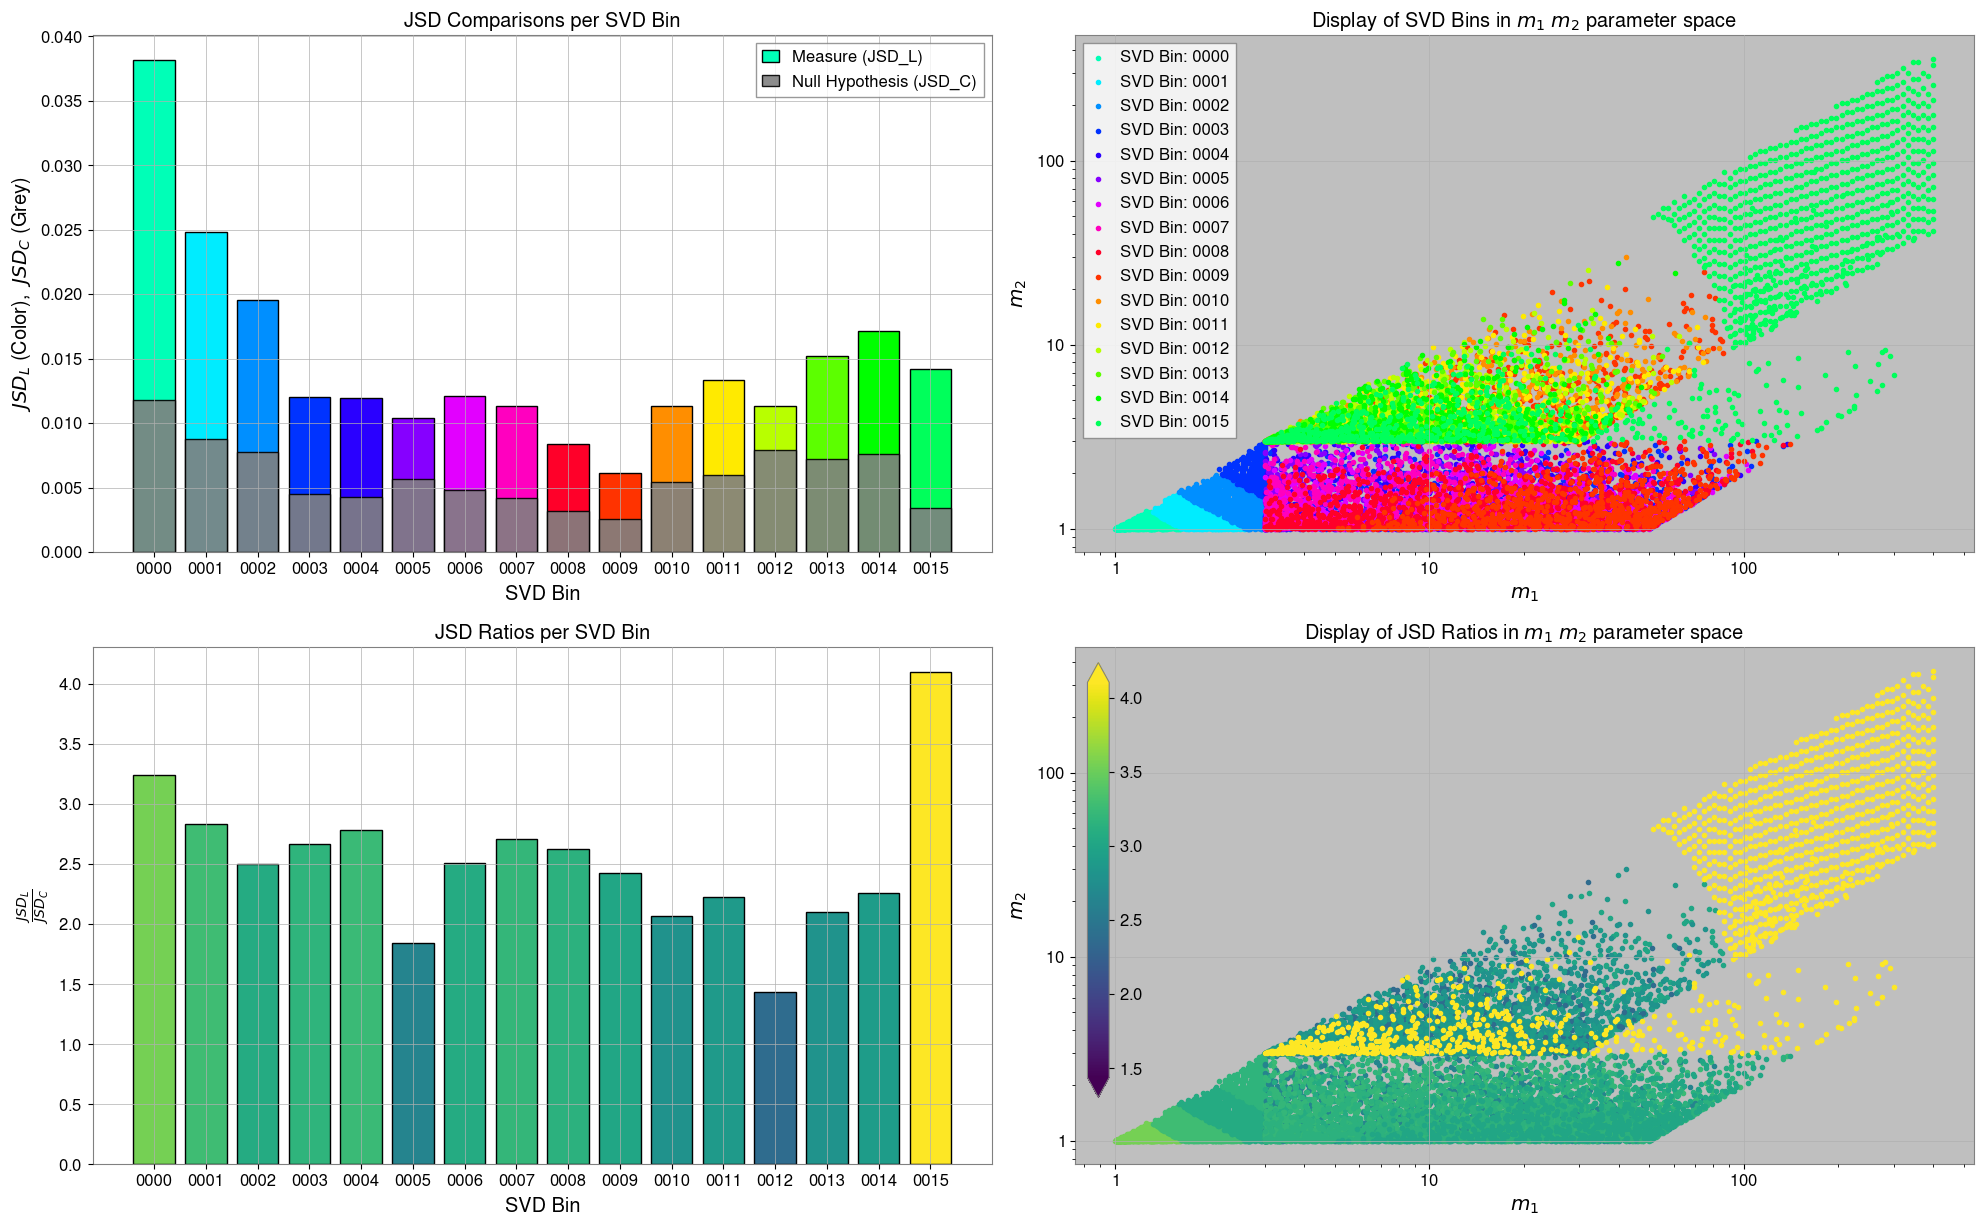

In [104]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

x_param = 'mass1'
y_param = 'mass2'
x_param_name = r"$m_1$"
y_param_name = r"$m_2$"
xLog = True
yLog = True

fig, ax = plt.subplots(2, 2, figsize = [20, 20/1.61])

svdBins = np.unique(triggersLIGO['SVD_Bin'])
svdBins_zfill = [str(svdBin).zfill(4) for svdBin in svdBins]
colors = [cm.gist_rainbow(svdBin/max(svdBins)) for svdBin in svdBins]
colors = colors[int(len(colors)/2):] + colors[:int(len(colors)/2)]
# np.random.shuffle(colors)
colors = {svdBins[i]:colors[i] for i in range(len(svdBins))}
JSD_LC = []
JSD_CC = []
ratios = []

for svdBin in svdBins:
    triggersLIGO_svd = triggersLIGO[triggersLIGO['SVD_Bin'] == svdBin]
    triggersCompare_svd = triggersCompare[triggersCompare['SVD_Bin'] == svdBin]
    triggersControl_svd = triggersControl[triggersControl['SVD_Bin'] == svdBin]
    bankParameters_svd = bankParameters[bankParameters['SVD_Bin'] == svdBin]
    
    JSD_LC += [jsd(triggersLIGO_svd[param], triggersCompare_svd[param])]
    JSD_CC += [jsd(triggersCompare_svd[param], triggersControl_svd[param])]
    ratios += [JSD_LC[-1]/JSD_CC[-1]]
    
    ax[0, 1].scatter(bankParameters_svd[x_param], bankParameters_svd[y_param], marker = '.', label = "SVD Bin: " + str(svdBin).zfill(4), color = colors[svdBin])
    
#----------------JSD Bar Plots-----------------

ax[0, 0].bar(svdBins_zfill, JSD_LC, edgecolor = 'black', label = 'Measure (JSD_L)', color = [colors[svdBin] for svdBin in svdBins])
ax[0, 0].bar(svdBins_zfill, JSD_CC, color = 'grey', edgecolor = 'black', alpha = 0.9, label = "Null Hypothesis (JSD_C)")
ax[0, 0].set_ylabel("$JSD_L$ (Color),  $JSD_C$ (Grey)")
ax[0, 0].set_xlabel("SVD Bin")
ax[0, 0].set_title("JSD Comparisons per SVD Bin")
ax[0, 0].legend()

#----------------Banks Parameter Scatter-----------------

ax[0, 1].set_xlabel(x_param_name)
ax[0, 1].set_ylabel(y_param_name)
ax[0, 1].set_title("Display of SVD Bins in " + x_param_name + " " + y_param_name + " parameter space")

if xLog:
    ax[0, 1].set_xscale('log')
if yLog:
    ax[0, 1].set_yscale('log')
ax[0, 1].legend()
ax[0, 1].set_facecolor([.75,.75,.75])

#----------------Gaussianity Bar Plot-----------------
colors_ratios = [cm.viridis(ratio/max(ratios)) for ratio in ratios]
ax[1, 0].bar(svdBins_zfill, ratios, edgecolor = 'black', color = colors_ratios)
ax[1, 0].set_title("JSD Comparisons and Ratio per SVD Bin")
ax[1, 0].set_xlabel("SVD Bin")
ax[1, 0].set_ylabel(r"$\frac{JSD_L}{JSD_C}$")
ax[1, 0].set_title("JSD Ratios per SVD Bin")

#----------------Gaussianity Bar Plot-----------------
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('right', size='0%', pad=0.0)
for i in range(len(svdBins)):
    bankParameters_svd = bankParameters[bankParameters['SVD_Bin'] == svdBins[i]]
    ax[1, 1].scatter(bankParameters_svd[x_param], bankParameters_svd[y_param], marker = '.', color = colors_ratios[i])

ax[1, 1].set_facecolor([.75,.75,.75])

if xLog:
    ax[1, 1].set_xscale('log')
if yLog:
    ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel(x_param_name)
ax[1, 1].set_ylabel(y_param_name)
norm = mpl.colors.Normalize(vmin=min(ratios), vmax=max(ratios))
cax.axis('off')
cbar = cax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='viridis'),
            ax=cax, extend='both', fraction=1)
ax[1, 1].set_title("Display of JSD Ratios in " + x_param_name + " " + y_param_name + " parameter space")


fig.tight_layout()

[(0.458674, 0.816363, 0.329727, 1.0),
 (0.24607, 0.73891, 0.452024, 1.0),
 (0.143303, 0.669459, 0.511215, 1.0),
 (0.185783, 0.704891, 0.485273, 1.0),
 (0.226397, 0.728888, 0.462789, 1.0),
 (0.144759, 0.519093, 0.556572, 1.0),
 (0.143303, 0.669459, 0.511215, 1.0),
 (0.202219, 0.715272, 0.476084, 1.0),
 (0.170948, 0.694384, 0.493803, 1.0),
 (0.130067, 0.651384, 0.521608, 1.0),
 (0.126453, 0.570633, 0.549841, 1.0),
 (0.119738, 0.603785, 0.5414, 1.0),
 (0.183898, 0.422383, 0.556944, 1.0),
 (0.124395, 0.578002, 0.548287, 1.0),
 (0.119423, 0.611141, 0.538982, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0)]

# Reading segments.xml.gz to segments.csv, Turn into its own command later

In [14]:
# import pandas a pd
# import numpy as np
# from ligo.lw import utils
# from ligo.lw import ligolw

# def parsePCDAta(pcdata):
#     data = pcdata.replace("\t","").split("\n")[1:-1]
#     data = [line.split(',') for line in data]
#     data = [[eval(d) for d in line if d != ""] for line in data]
#     return data

# class ContentHandler(ligolw.LIGOLWContentHandler):
#     pass
# file = 'gstlalRuns/sparse_banks_151234/segments.xml.gz'

# doc = utils.load_filename(file, contenthandler=ContentHandler, verbose = True)

# table_data = doc.childNodes[0].childNodes[4]
# columnNames = [col.Name for col in table_data.childNodes[:-1]]
# columnNames[-1] = 'ifo'
# values = parsePCDAta(table_data.childNodes[-1].pcdata)
# for i in range(len(values)):
#     values[i][-1] = ifoOrder[values[i][-1]]
# values = np.array(values).T
# df = pd.DataFrame({columnNames[i]:values[i] for i in range(len(columnNames))}).drop(["process:process_id","segment_id","start_time_ns","end_time_ns"], axis = 'columns')
# df.to_csv("sparse_banks_151234/segments.csv")



# Reading vetoes.xml.gz to vetoes.csv, Turn into its own command later

In [15]:
import pandas as pd
import numpy as np
from ligo.lw import utils
from ligo.lw import ligolw

def parsePCDAta(pcdata):
    data = pcdata.replace("\t","").split("\n")[1:-1]
    data = [line.split(',') for line in data]
    data = [[eval(d) for d in line if d != ""] for line in data]
    return data

class ContentHandler(ligolw.LIGOLWContentHandler):
    pass

ifoOrder = ['H1','L1','V1']

file = 'gstlalRuns/sparse_banks_151234/vetoes.xml.gz'

doc = utils.load_filename(file, contenthandler=ContentHandler, verbose = True)

table_data = doc.childNodes[0].childNodes[4]
columnNames = [col.Name for col in table_data.childNodes[:-1]]
columnNames[-1] = 'ifo'
values = parsePCDAta(table_data.childNodes[-1].pcdata)
for i in range(len(values)):
    values[i][-1] = ifoOrder[values[i][-1]]
values = np.array(values).T
df = pd.DataFrame({columnNames[i]:values[i] for i in range(len(columnNames))}).drop(["process:process_id","segment_id","start_time_ns","end_time_ns"], axis = 'columns')
df.to_csv("sparse_banks_151234/segments.csv")



reading 'gstlalRuns/sparse_banks_151234/vetoes.xml.gz' ...


In [38]:
triggersLIGO.columns

Index(['Unnamed: 0.1', 'process:process_id', 'ifo', 'end_time', 'end_time_ns',
       'eff_distance', 'coa_phase', 'mass1', 'mass2', 'snr', 'chisq',
       'chisq_dof', 'bank_chisq', 'bank_chisq_dof', 'sigmasq', 'spin1x',
       'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z', 'template_duration',
       'event_id', 'Gamma0', 'Gamma1', 'Gamma2', 'SVD Bin', 'alpha', 'alpha1',
       'alpha2', 'alpha3', 'alpha4', 'alpha5', 'alpha6', 'amp_order',
       'bandpass', 'beta', 'distance', 'eff_dist_g', 'eff_dist_h',
       'eff_dist_l', 'eff_dist_t', 'eff_dist_v', 'end_time_gmst', 'eta',
       'f_final', 'f_lower', 'g_end_time', 'g_end_time_ns', 'geocent_end_time',
       'geocent_end_time_ns', 'h_end_time', 'h_end_time_ns', 'inclination',
       'l_end_time', 'l_end_time_ns', 'latitude', 'longitude', 'mchirp',
       'numrel_data', 'numrel_mode_max', 'numrel_mode_min', 'phi0',
       'polarization', 'psi0', 'psi3', 'simulation_id', 'source', 't_end_time',
       't_end_time_ns', 'taper', '

# Other Plots

Number of BNS Templates: 3467
Number of NSBH Templates: 7810
Number of BBH Templates: 5352


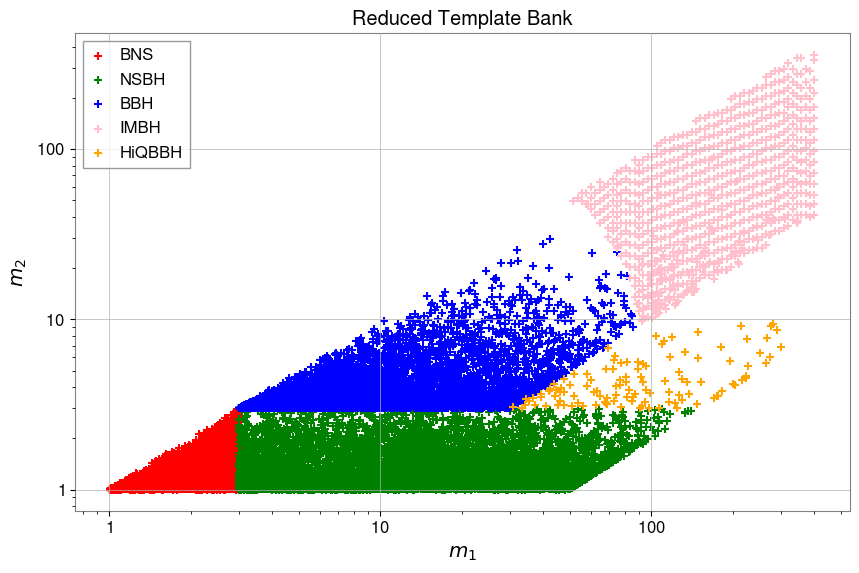

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
runName = 'sparse_banks_151234'

bankBNS = pd.read_csv(runName + "/bank_BNS.csv")
bankNSBH = pd.read_csv(runName + "/bank_NSBH.csv")
bankBBH = pd.read_csv(runName + "/bank_BBH.csv")
bankIMBH = pd.read_csv(runName + "/bank_IMBH.csv")
bankHiQBBH = pd.read_csv(runName + "/bank_HiQBBH.csv")

fig, ax = plt.subplots(figsize = [10, 10/1.61])
ax.scatter(bankBNS['mass1'], bankBNS['mass2'], marker = '+', color = 'red', label = 'BNS')
ax.scatter(bankNSBH['mass1'], bankNSBH['mass2'], marker = '+', color = 'green', label = 'NSBH')
ax.scatter(bankBBH['mass1'], bankBBH['mass2'], marker = '+', color = 'blue', label = 'BBH')
ax.scatter(bankIMBH['mass1'], bankIMBH['mass2'], marker = '+', color = 'pink', label = 'IMBH')
ax.scatter(bankHiQBBH['mass1'], bankHiQBBH['mass2'], marker = '+', color = 'orange', label = 'HiQBBH')
# x = np.linspace(1,500)
# ax.plot(x, 1/10*x)
# ax.plot(x, 100-x)


ax.set_xlabel(r"$m_1$")
ax.set_ylabel(r"$m_2$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Reduced Template Bank")
ax.legend()
fig.savefig(runName + "/plots/Reduced_Template_Bank_Plot.png")
print("Number of BNS Templates: " + str(len(bankBNS)))
print("Number of NSBH Templates: " + str(len(bankNSBH)))
print("Number of BBH Templates: " + str(len(bankBBH)))


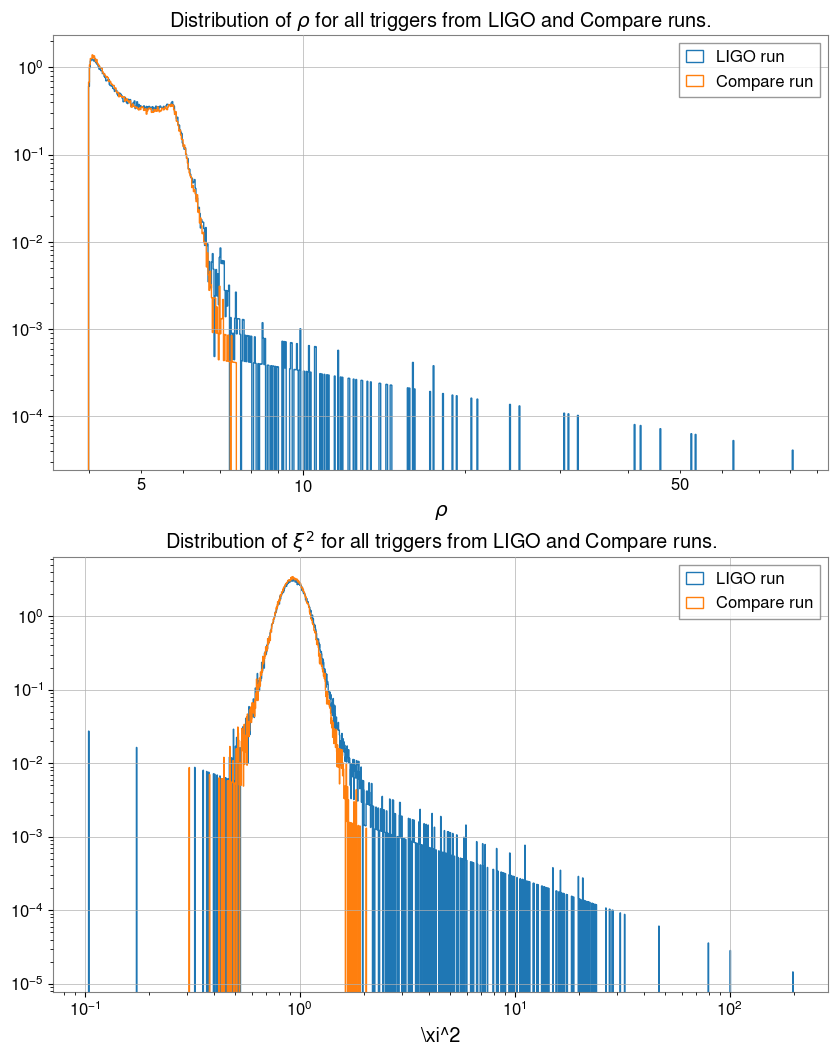

In [18]:
triggersLIGO = pd.read_csv(runName + "/triggers.csv")
triggersCompare = pd.read_csv(runName + "/triggers_gaussian_1.csv")

fig, ax = plt.subplots(2, 1, figsize = [10, 20/1.61])

logX = True
logY = True
bw = bestbandwidth(triggersLIGO['snr'])

if logX:
    data = triggersLIGO['snr']
    bins = np.exp(np.linspace(np.log(min(data)), np.log(max(data)), num = int((max(data) - min(data))/bw)))
ax[0].hist(triggersLIGO['snr'], density = True, histtype = 'step', bins = bins, label = "LIGO run")
ax[0].hist(triggersCompare['snr'], density = True, histtype = 'step', bins = bins, label = "Compare run")
if logX:
    ax[0].set_xscale('log')
if logY:
    ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel(r"$\rho$")
ax[0].set_title(r"Distribution of $\rho$ for all triggers from LIGO and Compare runs.")

logX = True
logY = True
bw = bestbandwidth(triggersLIGO['chisq'])

if logX:
    data = triggersLIGO['chisq']
    bins = np.exp(np.linspace(np.log(min(data)), np.log(max(data)), num = int((max(data) - min(data))/bw)))
ax[1].hist(triggersLIGO['chisq'], density = True, histtype = 'step', bins = bins, label = "LIGO run")
ax[1].hist(triggersCompare['chisq'], density = True, histtype = 'step', bins = bins, label = "Compare run")
if logX:
    ax[1].set_xscale('log')
if logY:
    ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlabel(r"\xi^2")
ax[1].set_title(r"Distribution of $\xi^2$ for all triggers from LIGO and Compare runs.")
fig.savefig(runName + "/plots/All_Triggers_Distribution")



In [19]:
import pandas as pd
bankBBH.to_csv(runName + "/bank_BBH.csv")
bankIMBH.to_csv(runName + "/bank_IMBH.csv")
bankHiQBBH.to_csv(runName + "/bank_HiQBBH.csv")


In [20]:
bankBBH.ignore_index()

AttributeError: 'DataFrame' object has no attribute 'ignore_index'

In [ ]:
triggersLIGO[['Gamma0', 'mass1', 'mass2' , 'snr', 'chisq']]

In [ ]:
print("Loading LIGO Run Triggers")
triggersLIGO = pd.read_csv(runName + '/triggers.csv').drop("Unnamed: 0", axis = "columns")
# Loading triggers for the Compare run
print("Loading Compare Run Triggers")
triggersCompare = pd.read_csv(runName + '/triggers_gaussian_1.csv').drop("Unnamed: 0", axis = "columns")
# Loading triggers for the Control run
print("Loading Control Run Triggers")
triggersControl = pd.read_csv(runName + '/triggers_gaussian_2.csv').drop("Unnamed: 0", axis = "columns")

#Loading Bank Parameters
bankParameters = pd.read_csv(runName + '/bank_' + bankCAT + '.csv')

# Filtering according to Interferometer
print("Filtering data by ifo")
triggersLIGO = triggersLIGO[triggersLIGO['ifo'] == ifo]
triggersCompare = triggersCompare[triggersCompare['ifo'] == ifo]
triggersControl = triggersControl[triggersControl['ifo'] == ifo]
segments = segments[segments['ifo'] == ifo]
glitches = glitches[glitches['ifo'] == ifo]

# Filtering according to segments
print("Filtering data by segments")
maskTriggersLIGO = [False for _ in range(len(triggersLIGO))]
maskTriggersCompare = [False for _ in range(len(triggersCompare))]
maskTriggersControl = [False for _ in range(len(triggersControl))]
maskGlitches = [False for _ in range(len(glitches))]
for idx, row in segments.iterrows():
    temp = list((triggersLIGO['end_time'] >= row['start_time']) & (triggersLIGO['end_time'] <= row['end_time']))
    maskTriggersLIGO = [x|y for (x,y) in zip(maskTriggersLIGO, temp)]
    
    temp = list((triggersCompare['end_time'] >= row['start_time']) & (triggersCompare['end_time'] <= row['end_time']))
    maskTriggersCompare = [x|y for (x,y) in zip(maskTriggersCompare, temp)]
    
    temp = list((triggersControl['end_time'] >= row['start_time']) & (triggersControl['end_time'] <= row['end_time']))
    maskTriggersControl = [x|y for (x,y) in zip(maskTriggersControl, temp)]
    
    temp = list((glitches['GPStime'] >= row['start_time']) & (glitches['GPStime'] <= row['end_time']))
    maskGlitches = [x|y for (x,y) in zip(maskGlitches, temp)]

triggersLIGO = triggersLIGO[maskTriggersLIGO]
triggersCompare = triggersCompare[maskTriggersCompare]
triggersControl = triggersControl[maskTriggersControl]
glitches = glitches[maskGlitches]
bankParameters['mtotal'] = bankParameters['mass1'] + bankParameters['mass2']
# Filtering according to Template Region
print("Filtering data by template region")
if bankCAT == 'BNS':
    triggersLIGO = triggersLIGO[(triggersLIGO['mass1'] < 3) & (triggersLIGO['mass2'] < 3)]
    triggersCompare = triggersCompare[(triggersCompare['mass1'] < 3) & (triggersCompare['mass2'] < 3)]
    triggersControl = triggersControl[(triggersControl['mass1'] < 3) & (triggersControl['mass2'] < 3)]
elif bankCAT == 'NSBH':
    triggersLIGO = triggersLIGO[(triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] < 3)]
    triggersCompare = triggersCompare[(triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] < 3)]
    triggersControl = triggersControl[(triggersControl['mass1'] >= 3) & (triggersControl['mass2'] < 3)]
elif bankCAT == 'BBH':
    triggersLIGO = triggersLIGO[(triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] >= 3)]
    triggersCompare = triggersCompare[(triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] >= 3)]
    triggersControl = triggersControl[(triggersControl['mass1'] >= 3) & (triggersControl['mass2'] >= 3)]

triggersLIGO['ID'] = [i for i in range(len(triggersLIGO))]
triggersCompare['ID'] = [i for i in range(len(triggersCompare))]
triggersControl['ID'] = [i for i in range(len(triggersControl))]
glitches['ID'] = [i for i in range(len(glitches))]

triggersLIGO = triggersLIGO.set_index("ID")
triggersCompare = triggersCompare.set_index("ID")
triggersControl = triggersControl.set_index("ID")
glitches = glitches.set_index("ID")

# Calculating chirp Mass (mchirp)
print("Calculating Chirp Mass")
triggersLIGO['mchirp'] = chirpMass(triggersLIGO['mass1'], triggersLIGO['mass2'])
triggersCompare['mchirp'] = chirpMass(triggersLIGO['mass1'], triggersLIGO['mass2'])
triggersControl['mchirp'] = chirpMass(triggersLIGO['mass1'], triggersLIGO['mass2'])
bankParameters['mchirp'] = chirpMass(bankParameters['mass1'], bankParameters['mass2'])

# Calculating Symmetric Mass Ratio (eta)
print("Calculating Symmetric Mass Ratio")
triggersLIGO['eta'] = eta(triggersLIGO['mass1'], triggersLIGO['mass2'])
triggersCompare['eta'] = eta(triggersLIGO['mass1'], triggersLIGO['mass2'])
triggersControl['eta'] = eta(triggersLIGO['mass1'], triggersLIGO['mass2'])
bankParameters['eta'] = eta(bankParameters['mass1'], bankParameters['mass2'])

# Calculating Total Mass (mtotal)
print("Calculating Total Mass")
triggersLIGO['mtotal'] = triggersLIGO['mass1'] + triggersLIGO['mass2']
triggersCompare['mtotal'] = triggersLIGO['mass1'] + triggersLIGO['mass2']
triggersControl['mtotal'] = triggersLIGO['mass1'] + triggersLIGO['mass2']
bankParameters['mtotal'] = bankParameters['mass1'] + bankParameters['mass2']

# Region 1 = mtotal [6, 10]

triggersLIGO_1 = triggersLIGO[(triggersLIGO['mtotal'] >= 6) & (triggersLIGO['mtotal'] <= 10)]
triggersCompare_1 = triggersCompare[(triggersCompare['mtotal'] >= 6) & (triggersCompare['mtotal'] <= 10)]
triggersControl_1 = triggersControl[(triggersControl['mtotal'] >= 6) & (triggersControl['mtotal'] <= 10)]
bankParameters_1 = bankParameters[(bankParameters['mtotal'] >= 6) & (bankParameters['mtotal'] <= 10)]

# Region 2 = loglog-circle of radius [[[R]]] around [[[(x,y)]]]

triggersLIGO_2 = triggersLIGO[(np.log(triggersLIGO['mass1']) - np.log(100))**2 + (np.log(triggersLIGO['mass2']) - np.log(30))**2 < np.log(3)**2]
triggersCompare_2 = triggersCompare[(np.log(triggersCompare['mass1']) - np.log(100))**2 + (np.log(triggersCompare['mass2']) - np.log(30))**2 < np.log(3)**2]
triggersControl_2 = triggersControl[(np.log(triggersControl['mass1']) - np.log(100))**2 + (np.log(triggersControl['mass2']) - np.log(30))**2 < np.log(3)**2]
bankParameters_2 = bankParameters[(np.log(bankParameters['mass1']) - np.log(100))**2 + (np.log(bankParameters['mass2']) - np.log(30))**2 < np.log(3)**2]

# Region 3 = mchirp [7, 11]

triggersLIGO_3 = triggersLIGO[(triggersLIGO['mchirp'] >= 7) & (triggersLIGO['mchirp'] <= 11)]
triggersCompare_3 = triggersCompare[(triggersCompare['mchirp'] >= 7) & (triggersCompare['mchirp'] <= 11)]
triggersControl_3 = triggersControl[(triggersControl['mchirp'] >= 7) & (triggersControl['mchirp'] <= 11)]
bankParameters_3 = bankParameters[(bankParameters['mchirp'] >= 7) & (bankParameters['mchirp'] <= 11)]

fig, ax = plt.subplots(figsize = [10, 10/1.61])
ax.scatter(bankBBH['mass1'], bankBBH['mass2'], marker = '+', color = 'black')
ax.scatter(bankParameters_1['mass1'], bankParameters_1['mass2'], marker = '+', color = 'orange', label = 'Region 1')
ax.scatter(bankParameters_2['mass1'], bankParameters_2['mass2'], marker = '+', color = 'blue', label = 'Region 2')
ax.scatter(bankParameters_3['mass1'], bankParameters_3['mass2'], marker = '+', color = 'green', label = 'Region 3')

ax.set_xlabel(r"$m_1$")
ax.set_ylabel(r"$m_2$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Different Regions being shown in the BBH Parameter Space")
ax.legend()
fig.savefig(runName + "/plots/Example_Regions_Template.png")
print("Number of BNS Templates: " + str(len(bankBNS)))
print("Number of NSBH Templates: " + str(len(bankNSBH)))
print("Number of BBH Templates: " + str(len(bankBBH)))


In [ ]:
fig, ax = plt.subplots(figsize = [10, 10/1.61])
bw = bestbandwidth(triggersLIGO_1['snr'])
minX = min(triggersLIGO_1['snr'])
maxX = max(triggersLIGO_1['snr'])
bins = np.exp(np.linspace(np.log(minX), np.log(maxX), num = int((maxX - minX)/(bw))))
ax.hist(triggersLIGO_1['snr'], density = True, bins = bins, color = 'blue', histtype = 'step', label = 'LIGO Run')
ax.hist(triggersCompare_1['snr'], density = True, bins = bins, color = 'black', histtype = 'step', label = 'Compare Run')
ax.legend()
ax.set_xlabel(r"$\rho$")
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(runName + "/plots/region_1_snr_distribution.png")


In [ ]:
fig, ax = plt.subplots(figsize = [10, 10/1.61])
bw = bestbandwidth(triggersLIGO_2['snr'])
minX = min(triggersLIGO_2['snr'])
maxX = max(triggersLIGO_2['snr'])
bins = np.exp(np.linspace(np.log(minX), np.log(maxX), num = int((maxX - minX)/(bw))))
ax.hist(triggersLIGO_2['snr'], density = True, bins = bins, color = 'blue', histtype = 'step', label = 'LIGO Run')
ax.hist(triggersCompare_2['snr'], density = True, bins = bins, color = 'black', histtype = 'step', label = 'Compare Run')
ax.legend()
ax.set_xlabel(r"$\rho$")
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(runName + "/plots/region_2_snr_distribution.png")


In [ ]:
fig, ax = plt.subplots(figsize = [10, 10/1.61])
bw = bestbandwidth(triggersLIGO_3['snr'])
minX = min(triggersLIGO_3['snr'])
maxX = max(triggersLIGO_3['snr'])
bins = np.exp(np.linspace(np.log(minX), np.log(maxX), num = int((maxX - minX)/(bw))))
ax.hist(triggersLIGO_3['snr'], density = True, bins = bins, color = 'blue', histtype = 'step', label = 'LIGO Run')
ax.hist(triggersCompare_3['snr'], density = True, bins = bins, color = 'black', histtype = 'step', label = 'Compare Run')
ax.legend()
ax.set_xlabel(r"$\rho$")
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(runName + "/plots/region_3_snr_distribution.png")


# Comparing all 5 approximant regions

In [ ]:
print("Loading LIGO Run Triggers")
triggersLIGO = pd.read_csv(runName + '/triggers.csv').drop("Unnamed: 0", axis = "columns")
# Loading triggers for the Compare run
print("Loading Compare Run Triggers")
triggersCompare = pd.read_csv(runName + '/triggers_gaussian_1.csv').drop("Unnamed: 0", axis = "columns")
# Loading triggers for the Control run
print("Loading Control Run Triggers")
triggersControl = pd.read_csv(runName + '/triggers_gaussian_2.csv').drop("Unnamed: 0", axis = "columns")

#Loading Bank Parameters
bankParameters = pd.read_csv(runName + '/bank_' + bankCAT + '.csv')

# Filtering according to Interferometer
print("Filtering data by ifo")
triggersLIGO = triggersLIGO[triggersLIGO['ifo'] == ifo]
triggersCompare = triggersCompare[triggersCompare['ifo'] == ifo]
triggersControl = triggersControl[triggersControl['ifo'] == ifo]
segments = segments[segments['ifo'] == ifo]
glitches = glitches[glitches['ifo'] == ifo]

# Filtering according to segments
print("Filtering data by segments")
maskTriggersLIGO = [False for _ in range(len(triggersLIGO))]
maskTriggersCompare = [False for _ in range(len(triggersCompare))]
maskTriggersControl = [False for _ in range(len(triggersControl))]
maskGlitches = [False for _ in range(len(glitches))]
for idx, row in segments.iterrows():
    temp = list((triggersLIGO['end_time'] >= row['start_time']) & (triggersLIGO['end_time'] <= row['end_time']))
    maskTriggersLIGO = [x|y for (x,y) in zip(maskTriggersLIGO, temp)]
    
    temp = list((triggersCompare['end_time'] >= row['start_time']) & (triggersCompare['end_time'] <= row['end_time']))
    maskTriggersCompare = [x|y for (x,y) in zip(maskTriggersCompare, temp)]
    
    temp = list((triggersControl['end_time'] >= row['start_time']) & (triggersControl['end_time'] <= row['end_time']))
    maskTriggersControl = [x|y for (x,y) in zip(maskTriggersControl, temp)]
    
    temp = list((glitches['GPStime'] >= row['start_time']) & (glitches['GPStime'] <= row['end_time']))
    maskGlitches = [x|y for (x,y) in zip(maskGlitches, temp)]

triggersLIGO = triggersLIGO[maskTriggersLIGO]
triggersCompare = triggersCompare[maskTriggersCompare]
triggersControl = triggersControl[maskTriggersControl]
glitches = glitches[maskGlitches]
bankParameters['mtotal'] = bankParameters['mass1'] + bankParameters['mass2']
# Filtering according to Template Region

JSD_L_snr = []
JSD_C_snr = []
JSD_L_chisq = []
JSD_C_chisq = []
L_triggers = []
bankCAT = ['BNS', 'NSBH', 'BBH', 'HiQBBH', 'IMBH']
print("Filtering data by template region")
for bankCAT in bankCAT:
    if bankCAT == 'BNS':
        maskLIGO = (triggersLIGO['mass1'] < 3) & (triggersLIGO['mass2'] < 3)
        maskCompare = (triggersCompare['mass1'] < 3) & (triggersCompare['mass2'] < 3)
        maskControl = (triggersControl['mass1'] < 3) & (triggersControl['mass2'] < 3)
    elif bankCAT == 'NSBH':
        maskLIGO = (triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] < 3)
        maskCompare = (triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] < 3)
        maskControl = (triggersControl['mass1'] >= 3) & (triggersControl['mass2'] < 3)
    elif bankCAT == 'BBH':
        maskLIGO = (triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] >= 3) & (triggersLIGO['mass1'] + triggersLIGO['mass2'] < 100) & (triggersLIGO['mass1']/triggersLIGO['mass2'] < 10)
        maskCompare = (triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] >= 3) & (triggersCompare['mass1'] + triggersCompare['mass2'] <= 100) & (triggersCompare['mass1']/triggersCompare['mass2'] < 10)
        maskControl = (triggersControl['mass1'] >= 3) & (triggersControl['mass2'] >= 3) & (triggersControl['mass1'] + triggersControl['mass2'] <= 100) & (triggersControl['mass1']/triggersControl['mass2'] < 10)
    elif bankCAT == 'IMBH':
        maskLIGO = (triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] >= 3) & (triggersLIGO['mass1'] + triggersLIGO['mass2'] >= 100) & (triggersLIGO['mass1']/triggersLIGO['mass2'] < 10)
        maskCompare = (triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] >= 3) & (triggersCompare['mass1'] + triggersCompare['mass2'] <= 100) & (triggersCompare['mass1']/triggersCompare['mass2'] < 10)
        maskControl = (triggersControl['mass1'] >= 3) & (triggersControl['mass2'] >= 3) & (triggersControl['mass1'] + triggersControl['mass2'] <= 100) & (triggersControl['mass1']/triggersControl['mass2'] < 10)
    elif bankCAT == 'HiQBBH':
        maskLIGO = (triggersLIGO['mass1'] >= 3) & (triggersLIGO['mass2'] >= 3) & (triggersLIGO['mass1']/triggersLIGO['mass2'] >= 10)
        maskCompare = (triggersCompare['mass1'] >= 3) & (triggersCompare['mass2'] >= 3) & (triggersCompare['mass1']/triggersCompare['mass2'] >= 10)
        maskControl = (triggersControl['mass1'] >= 3) & (triggersControl['mass2'] >= 3) & (triggersControl['mass1']/triggersControl['mass2'] >= 10)

    triggersLIGO_temp = triggersLIGO[maskLIGO]
    triggersCompare_temp = triggersCompare[maskCompare]
    triggersControl_temp = triggersControl[maskControl]
    
    JSD_L_snr += [jsd(triggersLIGO_temp['snr'], triggersCompare_temp['snr'])]
    JSD_C_snr += [jsd(triggersCompare_temp['snr'], triggersControl_temp['snr'])]
    JSD_L_chisq += [jsd(triggersLIGO_temp['chisq'], triggersCompare_temp['chisq'])]
    JSD_C_chisq += [jsd(triggersCompare_temp['chisq'], triggersControl_temp['chisq'])]
    L_triggers += [len(triggersLIGO_temp)]

L_triggers = np.array(L_triggers)/np.sum(L_triggers)

fig, ax = plt.subplots(3, 2, figsize = [20, 30/1.61])
ax[0, 0].bar(bankCAT, JSD_L_snr, color = 'red', edgecolor = 'k', label = 'Measure')
ax[0, 0].bar(bankCAT, JSD_C_snr, color = 'grey', edgecolor = 'k', label = 'Null Hypothesis', alpha = 0.8)
ax[0, 0].set_yscale('log')
ax[0, 0].legend()
ax[0, 0].set_title(r"JSD $\rho$ Measure for all 5 approximants over all the triggers")

ax[0, 1].bar(bankCAT, JSD_L_chisq, color = 'blue', edgecolor = 'k', label = 'Measure')
ax[0, 1].bar(bankCAT, JSD_C_chisq, color = 'grey', edgecolor = 'k', label = 'Null Hypothesis', alpha = 0.8)
ax[0, 1].set_yscale('log')
ax[0, 1].legend()
ax[0, 1].set_title(r"JSD $\xi^2$ Measure for all 5 approximants over all the triggers")

ax[1, 0].bar(bankCAT, np.array(JSD_L_snr)/np.array(JSD_C_snr), color = 'red', edgecolor = 'k', label = 'Measure')
ax[1, 0].set_yscale('log')
ax[1, 0].legend()
ax[1, 0].set_title(r"JSD $\rho$ Ratio (Measure/Contorl) for all 5 approximants over all the triggers")

ax[1, 1].bar(bankCAT, np.array(JSD_L_chisq)/np.array(JSD_C_chisq), color = 'blue', edgecolor = 'k', label = 'Measure')
ax[1, 1].set_yscale('log')
ax[1, 1].legend()
ax[1, 1].set_title(r"JSD $\xi^2$ Impact for all 5 approximants over all the triggers")

ax[2, 0].bar(bankCAT, np.array(JSD_L_snr)/np.array(JSD_C_snr)*L_triggers, color = 'red', edgecolor = 'k', label = 'Measure')
ax[2, 0].set_yscale('log')
ax[2, 0].legend()
ax[2, 0].set_title(r"JSD $\rho$ Impact for all 5 approximants over all the triggers")

ax[2, 1].bar(bankCAT, np.array(JSD_L_chisq)/np.array(JSD_C_chisq)*L_triggers, color = 'blue', edgecolor = 'k', label = 'Measure')
ax[2, 1].set_yscale('log')
ax[2, 1].legend()
ax[2, 1].set_title(r"JSD $\xi^2$ Impact for all 5 approximants over all the triggers")






    

    


# Notes
 - Make SNR Chisq/SNr^2 plots Superimpose gaussian and real
 - Share on GstLAL/CBC calls
 - Reformat Paper to PRD or Classical and Quantum Gravity

In [1]:
import sqlite3
import pandas as pd
from IPython.display import clear_output
import numpy as np

con = sqlite3.connect("gstlalRuns/sparse_banks_151234/rank/triggers/12645/H1L1V1-GSTLAL_TRIGGERS_ALL-1264528208-151234.sqlite")
# con = sqlite3.connect("gstlalRuns/sparse_banks_151234/rank/triggers/12645/H1L1V1-GSTLAL_TRIGGERS-1264528208-151234.sqlite")

cur = con.cursor()

def sql_fetch(con):
    cursorObj = con.cursor()
    cursorObj.execute('SELECT name from sqlite_master where type= "table"')
    print(cursorObj.fetchall())
sql_fetch(con)

table = 'coinc_event'
cur = con.execute('select * from ' + table)
names = list(map(lambda x: x[0], cur.description))
df_coinc = {name:[] for name in names}

for row in cur.execute('SELECT * FROM '  + table + ";"):
    for i in range(len(names)):
        df_coinc[names[i]] += [row[i]]
df_coinc = pd.DataFrame(df_coinc)

# fetching Map

table = 'coinc_event_map'
cur = con.execute('select * from ' + table)
names = list(map(lambda x: x[0], cur.description))
df_coinc_map = {name:[] for name in names}

for row in cur.execute('SELECT * FROM '  + table + ";"):
    for i in range(len(names)):
        df_coinc_map[names[i]] += [row[i]]
df_coinc_map = pd.DataFrame(df_coinc_map)

table = 'sngl_inspiral'
cur = con.execute('select * from ' + table)
names = list(map(lambda x: x[0], cur.description))
df_sngl_inspiral = {name:[] for name in names}

for row in cur.execute('SELECT * FROM '  + table + ";"):
    for i in range(len(names)):
        df_sngl_inspiral[names[i]] += [row[i]]
df_sngl_inspiral = pd.DataFrame(df_sngl_inspiral)

# table = 'coinc_inspiral'
# cur = con.execute('select * from ' + table)
# names = list(map(lambda x: x[0], cur.description))
# df_coinc_inspiral = {name:[] for name in names}

# for row in cur.execute('SELECT * FROM '  + table + ";"):
#     for i in range(len(names)):
#         df_coinc_inspiral[names[i]] += [row[i]]
# df_coinc_inspiral = pd.DataFrame(df_coinc_inspiral)
# df_coinc_inspiral

[('process',), ('process_params',), ('sim_inspiral',), ('sngl_inspiral',), ('coinc_definer',), ('coinc_event',), ('coinc_event_map',), ('time_slide',), ('coinc_inspiral',), ('segment_definer',), ('segment_summary',), ('segment',)]


In [ ]:
coinc_ids = df_coinc_map['coinc_event_id'].values
event_ids = df_coinc_map['event_id'].values
likelihoods = []
for i, row in df_sngl_inspiral.iterrows():
    if i % 1000 == 0:
        clear_output(wait = True)
        print("Sqlite Row: " + str(i) + "/" + str(len(df_sngl_inspiral)))
    event_id = row['event_id']
    coinc_id = df_coinc_map.set_index('event_id').loc[event_id]['coinc_event_id']
    if not isinstance(coinc_id, np.int64):
        coinc_id = coinc_id.iloc[0]
    likelihoods += [df_coinc.set_index('coinc_event_id').loc[coinc_id]['likelihood']]
df_sngl_inspiral['likelihood'] = likelihoods

Sqlite Row: 67000/70747


In [31]:
from ligo.lw import utils, ligolw
import pandas as pd
import numpy as np
def bankParser(bankFile):
    def myEval(val):
        if val != '':
            try:
                return eval(val)
            except:
                return val
        else:
            return np.nan

    class ContentHandler(ligolw.LIGOLWContentHandler):
        pass
    print("Loading Document")
    doc = utils.load_filename(bankFile, contenthandler=ContentHandler)
    print("Inferring SvdBin from Filename")
    svdBin = bankFile.split('/')[-1].split('-')[1].split('_')[0]
    print("Finding Banks in Files")
    bankIs = [i for i, row in enumerate(doc.childNodes[0].childNodes) if row.Name == 'gstlal_svd_bank_Bank']
    print("Reading Column Names")
    columns = []
    for row in doc.childNodes[0].childNodes[bankIs[0]].childNodes[0].childNodes:
        try:
            columns += [row.Name]
        except:
            pass
    print("Parsing Data")
    pcdata = doc.childNodes[0].childNodes[bankIs[0]].childNodes[0].childNodes[-1].pcdata
    pcdata = pcdata.replace("\t","").split("\n")
    pcdata = [data for data in pcdata if len(data) > 1]
    print("Initializing DataFrame as Dict")
    bank = {col:[] for col in columns}
    for i, col in enumerate(columns):
        bank[col] = [myEval(data.split(",")[i]) for data in pcdata[:-1] if len(data) > 1]
    print("Turning to DataFrame")
    bank = pd.DataFrame(bank)
    bank['SVD_Bin'] = [svdBin]*len(bank)
    
    return bank

bankFile = '/home/andre.guimaraes/public_html/gstlal/offline_analysis/background_investigation_gstlal_02/gstlalRuns/sparse_banks_151234/filter/svd_bank/12645/H1-0000_GSTLAL_SVD_BANK-1264528208-151234.xml.gz'
bank = bankParser(bankFile)


# svdBins_Gamma0 = {str(i).zfill(4):[] for i in range(16)}
# gamma0s = bank['Gamma0'].values.tolist()
# bank = bank.set_index('Gamma0')

# svdBins = []
# tau0s = []
# tau3s = []
# for i, row in df_sngl_inspiral.iterrows():
#     if row['Gamma0'] in gamma0s:
#         svdBins += [svdBin]
#         tau0s += [bank.loc[row['Gamma0']]['tau0']]
#         tau3s += [bank.loc[row['Gamma0']]['tau3']]
#     else:
#         svdBins += ['SomethingElse']
#         tau0s += ['not found']
#         tau3s += ['shit']

# df_sngl_inspiral['tau0'] = tau0s
# df_sngl_inspiral['tau3'] = tau3s


Loading Document
Inferring SvdBin from Filename
Finding Banks in Files
Reading Column Names
Parsing Data
Initializing DataFrame as Dict
Turning to DataFrame


In [83]:
from ligo.lw import utils, ligolw
import pandas as pd
import numpy as np
def bankParser(bankFile):
    def myEval(val):
        if val != '':
            try:
                return eval(val)
            except:
                return val
        else:
            return np.nan

    class ContentHandler(ligolw.LIGOLWContentHandler):
        pass
    print("Loading Document")
    doc = utils.load_filename(bankFile, contenthandler=ContentHandler)
    print("Inferring SvdBin from Filename")
    svdBin = bankFile.split('/')[-1].split('-')[1].split('_')[0]
    print("Finding Banks in Files")
    bankIs = [i for i, row in enumerate(doc.childNodes[0].childNodes) if row.Name == 'sngl_inspiral:table']
    print("Reading Column Names")
    columns = []
    for row in doc.childNodes[0].childNodes[bankIs[0]].childNodes:
        try:
            columns += [row.Name]
        except:
            pass
    print("Parsing Data")
    pcdata = doc.childNodes[0].childNodes[bankIs[0]].childNodes[-1].pcdata
    pcdata = pcdata.replace("\t","").split("\n")
    pcdata = [data for data in pcdata if len(data) > 1]
    print("Initializing DataFrame as Dict")
    bank = {col:[] for col in columns}
    for i, col in enumerate(columns):
        bank[col] = [myEval(data.split(",")[i]) for data in pcdata[:-1] if len(data) > 1]
    print("Turning to DataFrame")
    bank = pd.DataFrame(bank)
    bank['SVD_Bin'] = [svdBin]*len(bank)
    
    return bank

bankFile = '/home/andre.guimaraes/public_html/gstlal/offline_analysis/background_investigation_gstlal_02/gstlalRuns/sparse_banks_151234/split_bank/H1L1V1-0000_GSTLAL_SPLIT_BANK_0000-0-0.xml.gz'
# class ContentHandler(ligolw.LIGOLWContentHandler):
    # pass
# doc = utils.load_filename(bankFile, contenthandler=ContentHandler)
# doc.childNodes[0].childNodes[0].Name
bank = bankParser(bankFile)
bank

# svdBins_Gamma0 = {str(i).zfill(4):[] for i in range(16)}
# gamma0s = bank['Gamma0'].values.tolist()
# bank = bank.set_index('Gamma0')

# svdBins = []
# tau0s = []
# tau3s = []
# for i, row in df_sngl_inspiral.iterrows():
#     if row['Gamma0'] in gamma0s:
#         svdBins += [svdBin]
#         tau0s += [bank.loc[row['Gamma0']]['tau0']]
#         tau3s += [bank.loc[row['Gamma0']]['tau3']]
#     else:
#         svdBins += ['SomethingElse']
#         tau0s += ['not found']
#         tau3s += ['shit']

# df_sngl_inspiral['tau0'] = tau0s
# df_sngl_inspiral['tau3'] = tau3s


Loading Document
Inferring SvdBin from Filename
Finding Banks in Files
Reading Column Names
Parsing Data
Initializing DataFrame as Dict
Turning to DataFrame


Gamma0  Gamma1  Gamma2  Gamma3  Gamma4  Gamma5  Gamma6  Gamma7  Gamma8  \
0     265725       0       0       0       0       0       0       0       0   
1     222423       0       0       0       0       0       0       0       0   
2     264638       0       0       0       0       0       0       0       0   
3     217477       0       0       0       0       0       0       0       0   
4     221902       0       0       0       0       0       0       0       0   
..       ...     ...     ...     ...     ...     ...     ...     ...     ...   
391  1176686       0       0       0       0       0       0       0       0   
392  1153868       0       0       0       0       0       0       0       0   
393  1146496       0       0       0       0       0       0       0       0   
394  1159103       0       0       0       0       0       0       0       0   
395  1195392       0       0       0       0       0       0       0       0   

     Gamma9  ...    spin2z       tau0  tau2      tau3  tau4  tau5  \
0         0  ...  0.032383  592.32727     0  5.547345     0     0   
1         0  ...  0.036791  591.91974     0  5.545845     0     0   
2         0  ... -0.033214  591.53068     0  5.544359     0     0   
3         0  ...  0.006787  591.09835     0  5.542773     0     0   
4         0  ...  0.046147  590.52268     0  5.540591     0     0   
..      ...  ...       ...        ...   ...       ...   ...   ...   
391       0  ... -0.033963  517.29654     0  5.275853     0     0   
392       0  ... -0.026502  517.09563     0  5.254616     0     0   
393       0  ...  0.048366  516.72658     0  5.267360     0     0   
394       0  ... -0.043115  516.81155     0  5.252929     0     0   
395       0  ...  0.046412  516.31171     0  5.253507     0     0   

     template_duration  ttotal  sngl_inspiral:table  SVD_Bin  
0           606.474038       0                  NaN     0000  
1           606.130316       0                  NaN     0000  
2           605.669585       0                  NaN     0000  
3           605.202918       0                  NaN     0000  
4           604.700952       0                  NaN     0000  
..                 ...     ...                  ...      ...  
391         530.370788       0                  NaN     0000  
392         530.201642       0                  NaN     0000  
393         529.844772       0                  NaN     0000  
394         529.924147       0                  NaN     0000  
395         529.420448       0                  NaN     0000  

[396 rows x 66 columns]

In [89]:
splitMapFile = 'runResults/sparse_banks_151234/split_bank_map.csv'
df_split_Bank = pd.read_csv(splitMapFile, low_memory = False)
numberOfBins = len(np.unique(df_split_Bank['SVD_Bin']))

In [90]:
len(df_split_Bank['Gamma0'])

17600

In [91]:
len(np.unique(df_split_Bank['Gamma0']))

17600

In [48]:
15960/3

5320.0

In [62]:
df_svd_Bank.sort_values('Gamma0').iloc[9540:].head(50)#5,148,392

Unnamed: 0.1  Unnamed: 0   Gamma0  Gamma1  Gamma2  Gamma3  Gamma4  \
12774           361         361  5141970       5       0       0       0   
2134            361         361  5141970       5       0       0       0   
7454            361         361  5141970       5       0       0       0   
3665            334         334  5145875       9       0       0       0   
8985            334         334  5145875       9       0       0       0   
14305           334         334  5145875       9       0       0       0   
8593            331         331  5147120       8       0       0       0   
3273            331         331  5147120       8       0       0       0   
13913           331         331  5147120       8       0       0       0   
7434            341         341  5148965       5       0       0       0   
12754           341         341  5148965       5       0       0       0   
2114            341         341  5148965       5       0       0       0   
12360           336         336  5150046       4       0       0       0   
1720            336         336  5150046       4       0       0       0   
7040            336         336  5150046       4       0       0       0   
2466            303         303  5154201       6       0       0       0   
7786            303         303  5154201       6       0       0       0   
13106           303         303  5154201       6       0       0       0   
2110            337         337  5155239       5       0       0       0   
7430            337         337  5155239       5       0       0       0   
12750           337         337  5155239       5       0       0       0   
4915            129         129  5157533      14       0       0       0   
10235           129         129  5157533      14       0       0       0   
15555           129         129  5157533      14       0       0       0   
13103           300         300  5159403       6       0       0       0   
7783            300         300  5159403       6       0       0       0   
2463            300         300  5159403       6       0       0       0   
12747           334         334  5163208       5       0       0       0   
2107            334         334  5163208       5       0       0       0   
7427            334         334  5163208       5       0       0       0   
8217            345         345  5163905       7       0       0       0   
2897            345         345  5163905       7       0       0       0   
13537           345         345  5163905       7       0       0       0   
7026            322         322  5164551       4       0       0       0   
12346           322         322  5164551       4       0       0       0   
1706            322         322  5164551       4       0       0       0   
8626            364         364  5168094       8       0       0       0   
3306            364         364  5168094       8       0       0       0   
13946           364         364  5168094       8       0       0       0   
7789            306         306  5170085       6       0       0       0   
2469            306         306  5170085       6       0       0       0   
13109           306         306  5170085       6       0       0       0   
7784            301         301  5170747       6       0       0       0   
2464            301         301  5170747       6       0       0       0   
13104           301         301  5170747       6       0       0       0   
8614            352         352  5175007       8       0       0       0   
3294            352         352  5175007       8       0       0       0   
13934           352         352  5175007       8       0       0       0   
12354           330         330  5176278       4       0       0       0   
1714            330         330  5176278       4       0       0       0   

       Gamma5  Gamma6  Gamma7  ...    spin2z       tau0  tau2      tau3  tau4  \
12774       0       0       0  ...  0.006110  35.

In [93]:
len(triggers)

81783

In [94]:
len(triggersALL)

70747

In [102]:
len(set(triggers['event_id'].values).intersection(set(triggersALL['event_id'].values)))

60508

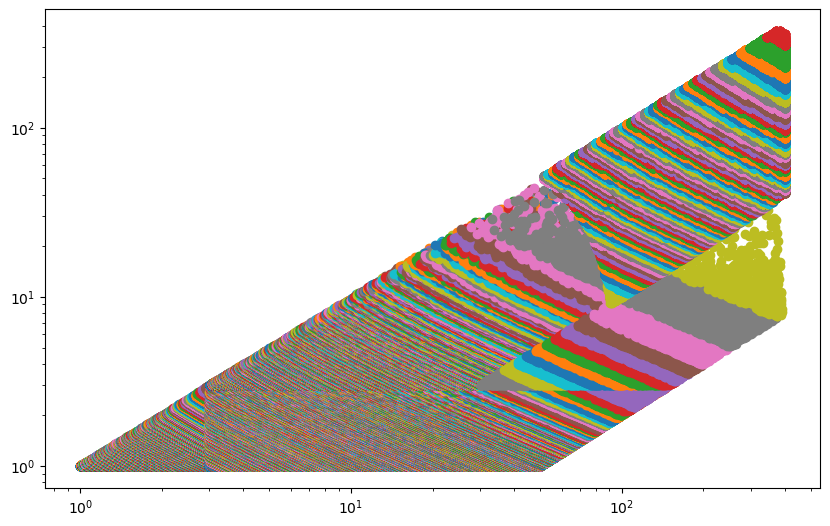

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
bankParameters = pd.read_csv("runResults/chunk24/split_bank_map.csv")
fig, ax = plt.subplots(figsize = [10, 10/1.61])
svdBins = np.unique(bankParameters['SVD_Bin'])
for svdBin in svdBins:
    bankParameters_svd = bankParameters[bankParameters['SVD_Bin'] == svdBin]
    ax.scatter(bankParameters_svd['mass1'], bankParameters_svd['mass2'])
ax.set_xscale('log')
ax.set_yscale('log')

# ax.plot([3,3],[1,3], '--', color = 'k', linewidth = 2)
# ax.plot([1,3],[1,3], '--', color = 'k', linewidth = 2)
# ax.plot([1,3],[1,1], '--', color = 'k', linewidth = 2)
# ax.plot([3,155],[3,3], '--', color = 'k', linewidth = 2)
# ax.plot([3,54],[1,1], '--', color = 'k', linewidth = 2)
# ax.plot([54,155],[1,3], '--', color = 'k', linewidth = 2)
# ax.plot([54,155],[1,3], '--', color = 'k', linewidth = 2)
# ax.plot([3,400],[3,400], '--', color = 'k', linewidth = 2)
# ax.plot([33,400],[3,40], '--', color = 'k', linewidth = 2)
# ax.plot([400,400],[40,400], '--', color = 'k', linewidth = 2)
# ax.plot([155,400],[3,10], '--', color = 'k', linewidth = 2)

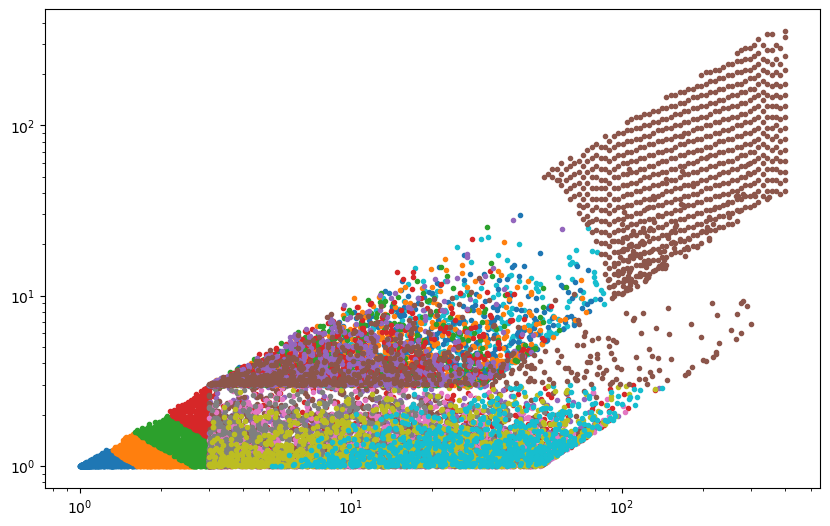

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
bankParameters = pd.read_csv("runResults/sparse_banks_151234/split_bank_map.csv")
fig, ax = plt.subplots(figsize = [10, 10/1.61])
svdBins = np.unique(bankParameters['SVD_Bin'])
for svdBin in svdBins:
    bankParameters_svd = bankParameters[bankParameters['SVD_Bin'] == svdBin]
    ax.scatter(bankParameters_svd['mass1'], bankParameters_svd['mass2'], marker = '.')
ax.set_xscale('log')
ax.set_yscale('log')

# ax.plot([3,3],[1,3], '--', color = 'k', linewidth = 2)
# ax.plot([1,3],[1,3], '--', color = 'k', linewidth = 2)
# ax.plot([1,3],[1,1], '--', color = 'k', linewidth = 2)
# ax.plot([3,155],[3,3], '--', color = 'k', linewidth = 2)
# ax.plot([3,54],[1,1], '--', color = 'k', linewidth = 2)
# ax.plot([54,155],[1,3], '--', color = 'k', linewidth = 2)
# ax.plot([54,155],[1,3], '--', color = 'k', linewidth = 2)
# ax.plot([3,400],[3,400], '--', color = 'k', linewidth = 2)
# ax.plot([33,400],[3,40], '--', color = 'k', linewidth = 2)
